# Setups, Installations and Imports

This loss landscape analysis for MIMO is originally borrowed from the paper *Deep Ensembles: A Loss Landscape Perspective* by Fort et. al.
Code is available here: https://github.com/ayulockin/LossLandscape


In [ ]:
!nvidia-smi

Mon Dec 13 14:05:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import resnet50


In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import io
import itertools
from sklearn.metrics import confusion_matrix

# Download and Prepare Dataset

#### MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CLASS_NAMES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


#### Dataloader

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
M = 3
tf.random.set_seed(1)

# For MNIST: 
# reshape to fit to model. Add dim for the 1 color channel
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)
# Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
x_test = x_test[:9999,:,:,:]
y_test = y_test[:9999,:]

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

trainloader_1 = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(2)
    .prefetch(AUTO)
)
trainloader = (
    trainloader_1
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader_1 = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(2) # tried drop_remainder=True
    .prefetch(AUTO)
)

testloader = (
    trainloader_1
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Model

In [ ]:
# Dense multihead for multiple outputs, as Implemented in the MIMO paper.
# Here applied to the Loss Landscape analysis
# coding=utf-8
# Copyright 2020 The <> Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

class DenseMultihead(tf.keras.layers.Dense):
    """Multiheaded output layer."""

    def __init__(self,
                 units,
                 ensemble_size=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super().__init__(
            units=units * ensemble_size,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.ensemble_size = ensemble_size
        #self.hellobro()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # NOTE: This restricts this layer from being called on tensors of ndim > 2.
        outputs = super().call(inputs)
        outputs = tf.reshape(outputs, [batch_size,
                                       self.ensemble_size,
                                       self.units // self.ensemble_size])
        return outputs

    def get_config(self):
        config = {
            'units': self.units // self.ensemble_size,
            'ensemble_size': self.ensemble_size,
        }
        new_config = super().get_config()
        new_config.update(config)
        return new_config

In [ ]:
tf.keras.backend.clear_session()

# Modified model to use the MIMO architecture
"""
Code from the mimo implementation
input_shape: tf.Tensor. The input shape must be (ensemble_size, width,
    height, channels).
"""
num_classes = 10
ensemble_size = 2
input_shape = list([ensemble_size, IMG_SHAPE, IMG_SHAPE, 1])
inputs = tf.keras.layers.Input(shape=input_shape)

x = tf.keras.layers.Permute([2, 3, 4, 1])(inputs)
#if ensemble_size != input_shape[0]:
#    raise ValueError('the first dimension of input_shape must be ensemble_size')
x = tf.keras.layers.Reshape(input_shape[1:-1] +
                              [input_shape[-1] * ensemble_size])(x)


a = keras.layers.Conv2D(16, (3,3), padding='same')(x)
x = keras.activations.relu(a)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) # Tried with 1

x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
x = keras.activations.relu(x)
x = keras.layers.MaxPooling2D(2, strides=2)(x)

x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
x = keras.activations.relu(x)
x = keras.layers.MaxPooling2D(2, strides=2)(x)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)

# outputs = keras.layers.Dense(10, activation='softmax')(x)
"""
Outputs as prensented in the MIMO paper (taken from their implementation)
"""
outputs = DenseMultihead(
      num_classes,
      kernel_initializer='he_normal', # TODO: check this! what should this be?
      activation='softmax', # this is changed from the MIMO implementation
      ensemble_size=ensemble_size)(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

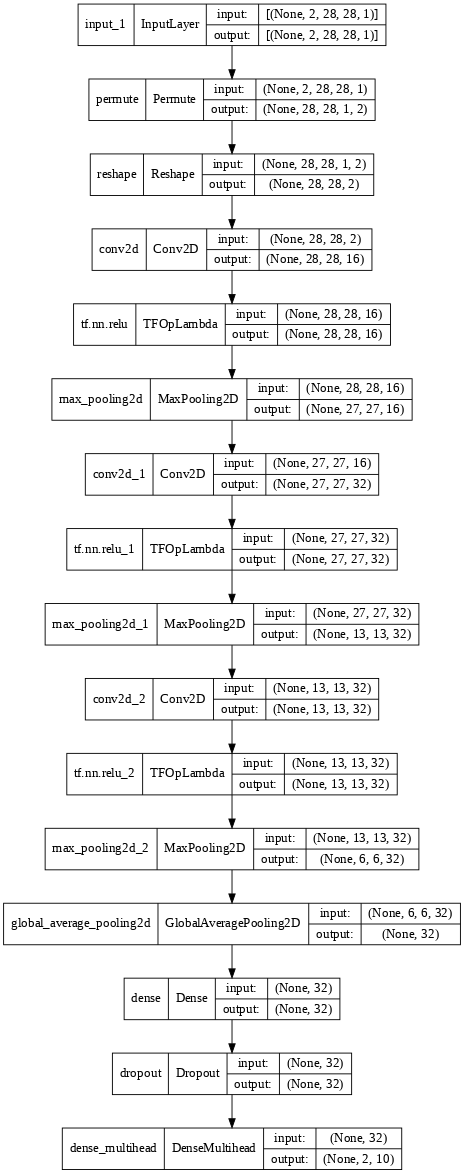

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='small_cnn.png', show_shapes=True, show_layer_names=True, dpi=65
)

# Callbacks

#### LR Scheduler

In [ ]:
# Custom Learning Rate schedule as mentioned in the LossLandscape paper
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1.6*1e-3),
    (9, (1.6*1e-3)/2),
    (19, (1.6*1e-3)/4),
    (29, (1.6*1e-3)/8),
]

def lr_schedule(epoch):
    if (epoch >= 0) & (epoch < 9):
        return LR_SCHEDULE[0][1]
    elif (epoch >= 9) & (epoch < 19):
        return LR_SCHEDULE[1][1]
    elif (epoch >= 19) & (epoch < 29):
        return LR_SCHEDULE[2][1]
    else:
        return LR_SCHEDULE[3][1]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

#### Model Checkpoint

In [ ]:
SAVE_PATH = 'drive/MyDrive/PreactivationExtraction/MNIST_SmallCNN_CheckpointID_1/'

In [ ]:
def save_model(epoch, logs):
  model.save(SAVE_PATH+'small_cnn_checkpoint_{}.tf'.format(epoch))

save_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model, verbose=True)

# Initialize Model

In [ ]:
#keras.backend.clear_session()
#model = Model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 28, 28, 1)]    0         
                                                                 
 permute (Permute)           (None, 28, 28, 1, 2)      0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        304       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 16)       0         
 )                                                               
                                                             

# Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Train

In [ ]:
EPOCHS = 40

start = time.time()
print(trainloader)
print(testloader)
_ = model.fit(trainloader,
          epochs=EPOCHS,
          verbose=2,
          validation_data=testloader,
          callbacks=[lr_callback,
                     save_callback])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))

<PrefetchDataset shapes: ((None, None, 28, 28, 1), (None, None, 1)), types: (tf.float32, tf.uint8)>
<PrefetchDataset shapes: ((None, None, 28, 28, 1), (None, None, 1)), types: (tf.float32, tf.uint8)>

Epoch 00001: LearningRateScheduler setting learning rate to 0.0016.
Epoch 1/40
INFO:tensorflow:Assets written to: drive/MyDrive/PreactivationExtraction/MNIST_SmallCNN_CheckpointID_1/small_cnn_checkpoint_0.tf/assets
235/235 - 22s - loss: 1.9880 - accuracy: 0.2700 - val_loss: 1.5473 - val_accuracy: 0.4651 - lr: 0.0016 - 22s/epoch - 92ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0016.
Epoch 2/40
INFO:tensorflow:Assets written to: drive/MyDrive/PreactivationExtraction/MNIST_SmallCNN_CheckpointID_1/small_cnn_checkpoint_1.tf/assets
235/235 - 12s - loss: 1.3890 - accuracy: 0.5116 - val_loss: 1.1722 - val_accuracy: 0.5914 - lr: 0.0016 - 12s/epoch - 52ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0016.
Epoch 3/40
INFO:tensorflow:Assets written to:

# Evaluate

In [ ]:
loss, accuracy = model.evaluate(testloader)
print("Test Error Rate: ", round((1-accuracy)*100, 2), '%')

235/235 [==============================] - 5s 21ms/step - loss: 0.2743 - accuracy: 0.9181
Test Error Rate:  8.19 %


# Investigating Network Separation


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CLASS_NAMES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# AUTO = tf.data.experimental.AUTOTUNE
# BATCH_SIZE = 128
# IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
# M = 3
# tf.random.set_seed(1)

# # For MNIST: 
# # reshape to fit to model. Add dim for the 1 color channel
# x_train = np.expand_dims(x_train, axis=3)
# y_train = np.expand_dims(y_train, axis=1)
# x_test = np.expand_dims(x_test, axis=3)
# y_test = np.expand_dims(y_test, axis=1)
# # Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
from sklearn.utils import shuffle
x_test, y_test = shuffle(x_test, y_test)
x_train, y_train = shuffle(x_train, y_train)
test_image_len=100
x_test = x_test[:test_image_len,:,:]
y_test = y_test[:test_image_len]

x_train = x_train[:test_image_len,:,:]
y_train = y_train[:test_image_len]

# trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# def preprocess_image(image, label):
#   img = tf.cast(image, tf.float32)
#   img = img/255.

#   return img, label

# trainloader_1 = (
#     trainloader
#     .shuffle(1024)
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(3)
#     .prefetch(AUTO)
# )
# trainloader = (
#     trainloader_1
#     .shuffle(1024)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# testloader_1 = (
#     testloader
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE) # tried drop_remainder=True
#     .prefetch(AUTO)
# )

# testloader = (
#     testloader_1
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )


AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
M = 3
tf.random.set_seed(1)

# For MNIST: 
# reshape to fit to model. Add dim for the 1 color channel
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)
# Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
# x_test = x_test[:9999,:,:,:]
# y_test = y_test[:9999,:]

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

# def tile_image(image, label):
#   print(image.shape)
#   # labels = tf.tile(tf.expand_dims(label, 1), [1, 3])
#   images = tf.tile(tf.expand_dims(image, 1), [1, 3, 1, 1, 1])
#   images = tf.squeeze(images, axis=0)
#   print(images.shape)
#   return images,label

def tile_image(image, label):
  print(label.shape)
  labels_tiled = tf.tile(tf.expand_dims(label, 2), [1, 3,1])
  images = tf.tile(tf.expand_dims(image, 1), [1, M, 1, 1, 1])
  images = tf.squeeze(images, axis=0)
  # label = tf.squeeze(labels_tiled, axis=0)
  return images,label

trainloader_1 = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(1)
    .prefetch(AUTO)
)
trainloader = (
    trainloader_1
    .shuffle(1024)
    .batch(test_image_len)
    .prefetch(AUTO)
)

# testloader_1 = (
#     testloader
#     .map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(test_image_len) # tried drop_remainder=True
#     .prefetch(AUTO)
# )

# testloader = (
#     testloader_1
#     .map(tile_image)
#     .batch(test_image_len)
#     .prefetch(AUTO)
# )

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
# Load the model! - this directory contain folders of the model at each epoch
ROOT_PATH = 'drive/MyDrive/PreactivationExtraction/'
## SmallCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = ROOT_PATH+'MNIST_SmallCNN_CheckpointID_1/'
same_model_ckpts = os.listdir(MODEL_PATH)
print(len(same_model_ckpts))

40


In [ ]:
# sort the models
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

same_model_ckpts = sorted_nicely(same_model_ckpts)
same_model_ckpts[:5]

['small_cnn_checkpoint_0.tf',
 'small_cnn_checkpoint_1.tf',
 'small_cnn_checkpoint_2.tf',
 'small_cnn_checkpoint_3.tf',
 'small_cnn_checkpoint_4.tf']

## Conditional Variance

In [ ]:
for im, lb in trainloader:
  images, labels= im,lb
tf.concat((images[0],images[0]), axis=(0)).shape

TensorShape([2, 28, 28, 1])

In [ ]:
for im, lb in trainloader:
  images, labels= im,lb
change_x2=np.empty((99,2,28,28,1))
for i,image_change in enumerate(images[1:]):
    change_x2[i,0,:,:] = images[0]
    change_x2[i,1,:,:]= image_change

change_x1=np.empty((99,2,28,28,1))
for i,image_change in enumerate(images[1:]):
    change_x2[i,0,:,:] = image_change
    change_x2[i,1,:,:]= images[0]

all_x1_change_x2=np.empty((100,100,2,28,28,1))
for i in range(len(images)):
  for j in range(len(images)):
    all_x1_change_x2[i,j,0,:,:] = images[i] #fix
    all_x1_change_x2[i,j,1,:,:]= images[j]

all_x2_change_x1=np.empty((100,100,2,28,28,1))
for i in range(len(images)):
  for i in range(len(images)):
    all_x1_change_x2[i,j,0,:,:] = images[j]
    all_x1_change_x2[i,j,1,:,:]= images[i] #fix



In [ ]:
var_x1=np.nan_to_num(np.var(activations_x1,axis=0))
var_x2=np.nan_to_num(np.var(activations_x2,axis=0))


In [ ]:

model = tf.keras.models.load_model(MODEL_PATH+'/'+same_model_ckpts[-1])
pre_activations = keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
for im, lb in trainloader:
  images, labels= im,lb

print(images.shape)
total_x0=[]
for i in range(len(images)):
  fix0=[]
  for j in range(len(images)):
    act=pre_activations(tf.expand_dims(tf.concat((images[i],images[j]), axis=(0)),axis=0))
    fix0.append(np.nan_to_num(act).reshape(-1))
  total_x0.append(fix0)

total_x1=[]
for i in range(len(images)):
  fix1=[]
  for j in range(len(images)):
    act=pre_activations(tf.expand_dims(tf.concat((images[j],images[i]), axis=(0)),axis=0))
    fix1.append(np.nan_to_num(act).reshape(-1))
  total_x1.append(fix1)
  # act=pre_activations.predict(images[:2])
  # print(act[0]- act[1])
# print(np.nan_to_num(act).reshape(2,-1))
#   activations_x1[i,:,:] = np.nan_to_num(act).reshape(100,-1)

# for i, images in enumerate(all_x2_change_x1):
#   act=pre_activations.predict(images)
#   print(act.sum())
# # print(np.nan_to_num(act).reshape(2,-1))
#   activations_x2[i,:,:] = np.nan_to_num(act).reshape(100,-1)


(100, 1, 28, 28, 1)


In [ ]:
varx0=[]
for i in range(len(total_x0)):
  varx0.append(np.var(total_x0[i],axis=0))

varx1=[]
for i in range(len(total_x1)):
  varx1.append(np.var(total_x1[i],axis=0))


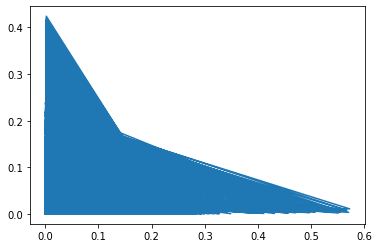

In [ ]:
meanx0=np.mean(varx0,axis=0)
meanx1=np.mean(varx1,axis=0)

plt.plot(meanx0,meanx1)

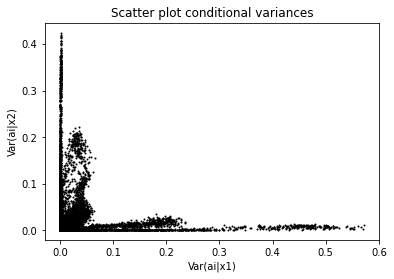

In [ ]:
plt.scatter(meanx0,meanx1, c='k',s=1)
plt.title("Scatter plot conditional variances")
plt.xlabel("Var(ai|x1)")
plt.ylabel("Var(ai|x2)")
plt.savefig("scatter.png",dpi=1000)

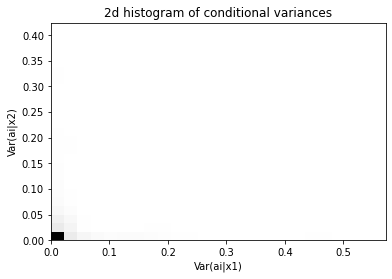

In [ ]:
plt.hist2d(meanx0,meanx1,bins=[25,25], norm=plt.Normalize() ,cmap="gray_r")
plt.title("2d histogram of conditional variances")
plt.xlabel("Var(ai|x1)")
plt.ylabel("Var(ai|x2)")
plt.savefig("hist.png",dpi=1000)